DM Project - Machine Learning - 2024-2025 - FEUP

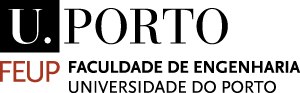

Students (IF) : Iliès Sghiar (1), Lucas Nakajima (1)  & Rodrigo Pinheiro (1)

Github LINK (where there are more results in AC.ipynb like grid search, voting classifier) : https://github.com/Lucasnakajima/Data-Mining/



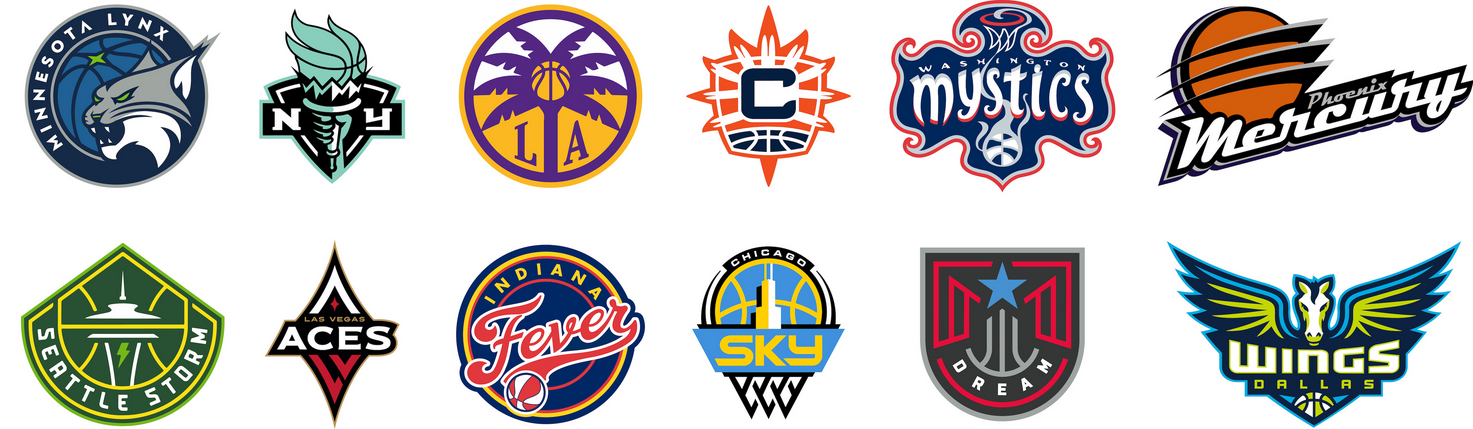


In [291]:
import gdown
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, DMatrix, train as xgb_train
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from numpy.polynomial.polynomial import Polynomial


In [292]:
zipId = '1RML363yBzB-uEnzQpajqxXg4aeSnP3Jh'

gdown.download(f'https://drive.google.com/uc?id={zipId}', 'data.zip', quiet=False)

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Downloading...
From: https://drive.google.com/uc?id=1RML363yBzB-uEnzQpajqxXg4aeSnP3Jh
To: /content/data.zip
100%|██████████| 99.9k/99.9k [00:00<00:00, 63.5MB/s]


In [293]:
awards_players = pd.read_csv('awards_players.csv')
coaches = pd.read_csv('coaches.csv')
players = pd.read_csv('players.csv')
players_teams = pd.read_csv('players_teams.csv')
series_post = pd.read_csv('series_post.csv')
teams = pd.read_csv('teams.csv')
teams_post = pd.read_csv('teams_post.csv')

# Data Understanding

In [294]:
teams['playoff'] = teams['playoff'].replace({'Y': 1, 'N': 0})

<ipython-input-294-f6052b3ba99b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  teams['playoff'] = teams['playoff'].replace({'Y': 1, 'N': 0})


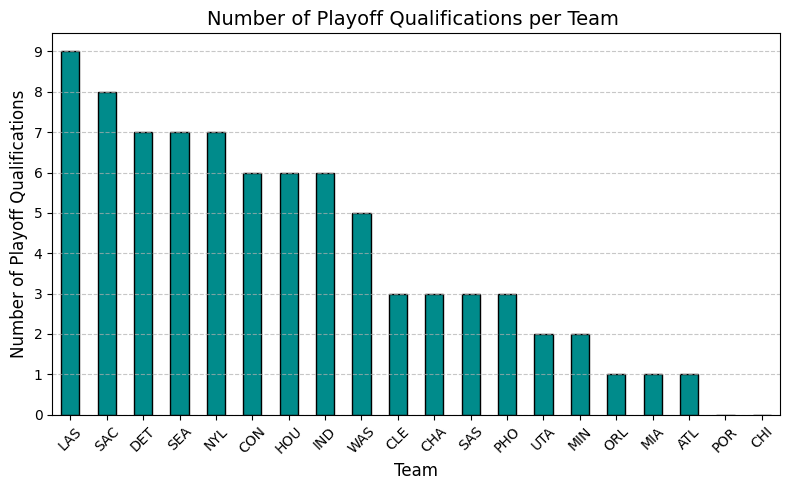

In [295]:
playoff_count = teams.groupby('tmID')['playoff'].sum()
playoff_count = playoff_count.sort_values(ascending=False)



plt.figure(figsize=(8, 5))
playoff_count.plot(kind='bar', color='darkcyan', edgecolor='black')

max_playoff = playoff_count.max()
plt.yticks(range(0, max_playoff + 1, 1))

plt.title('Number of Playoff Qualifications per Team ', fontsize=14)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Number of Playoff Qualifications', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

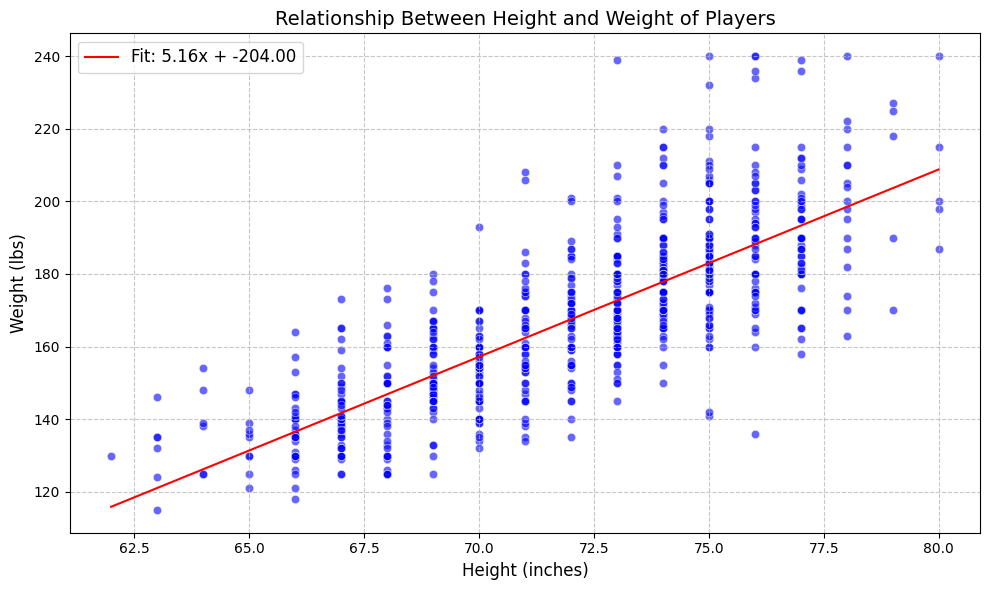

In [296]:
df_cleaned = players.dropna(subset=['height', 'weight'])

Q1_height = df_cleaned['height'].quantile(0.25) # we dont display outliers
Q3_height = df_cleaned['height'].quantile(0.75)
IQR_height = Q3_height - Q1_height

Q1_weight = df_cleaned['weight'].quantile(0.25)
Q3_weight = df_cleaned['weight'].quantile(0.75)
IQR_weight = Q3_weight - Q1_weight

df_filtered = df_cleaned[
    (df_cleaned['height'] >= Q1_height - 1.5 * IQR_height) &
    (df_cleaned['height'] <= Q3_height + 1.5 * IQR_height) &
    (df_cleaned['weight'] >= Q1_weight - 1.5 * IQR_weight) &
    (df_cleaned['weight'] <= Q3_weight + 1.5 * IQR_weight)
]

X = df_filtered['height']
Y = df_filtered['weight']

p = Polynomial.fit(X, Y, deg=1)

x_range = np.linspace(X.min(), X.max(), 500)
y_fit = p(x_range)

coef = p.convert().coef
equation = f"{coef[1]:.2f}x + {coef[0]:.2f}"

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X, y=Y, color='blue', alpha=0.6)

plt.plot(x_range, y_fit, color='red', label=f"Fit: {equation}")

plt.title('Relationship Between Height and Weight of Players', fontsize=14)
plt.xlabel('Height (inches)', fontsize=12)
plt.ylabel('Weight (lbs)', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

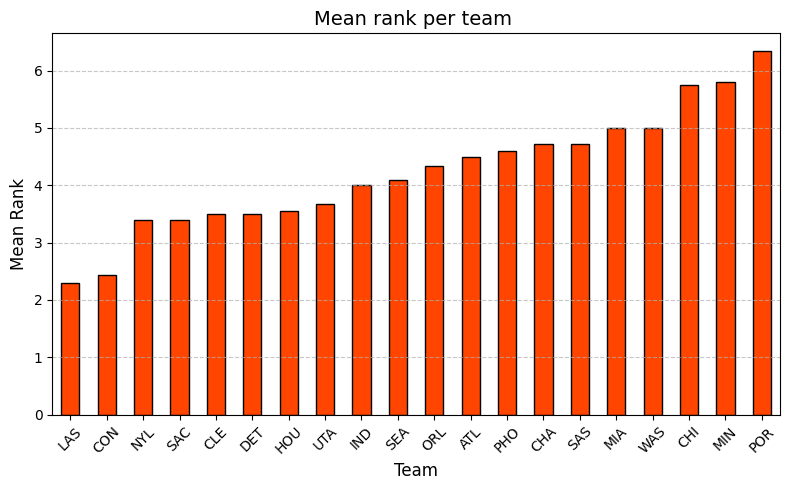

In [297]:
import seaborn as sns
playoff_count = teams.groupby('tmID')['rank'].mean()
playoff_count = playoff_count.sort_values(ascending=True)



plt.figure(figsize=(8, 5))
playoff_count.plot(kind='bar', color='orangered', edgecolor='black')

max_playoff = playoff_count.max()
plt.yticks(range(0, 7, 1))
plt.title('Mean rank per team ', fontsize=14)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Mean Rank', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

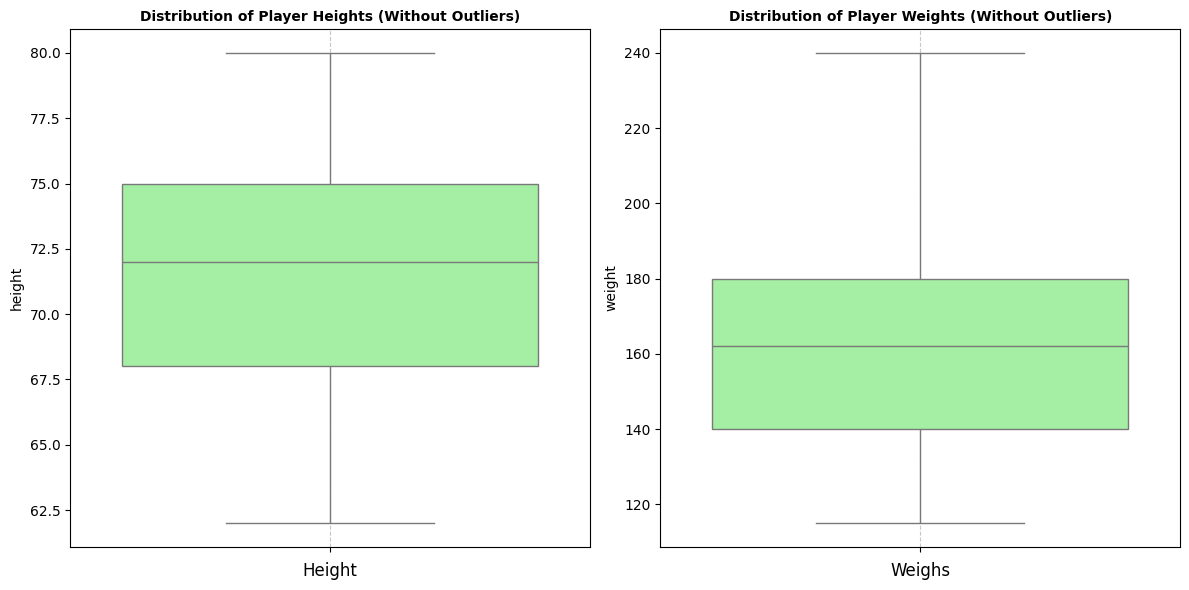

In [298]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)

sns.boxplot(data=players, y='height', showfliers=False, color='palegreen')

plt.title('Distribution of Player Heights (Without Outliers)', fontsize=10, fontweight='bold')
plt.xlabel('Height', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.boxplot(data=players, y='weight', showfliers=False, color='palegreen')

plt.title('Distribution of Player Weights (Without Outliers)', fontsize=10, fontweight='bold')
plt.xlabel('Weighs', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)


plt.tight_layout()


plt.show()

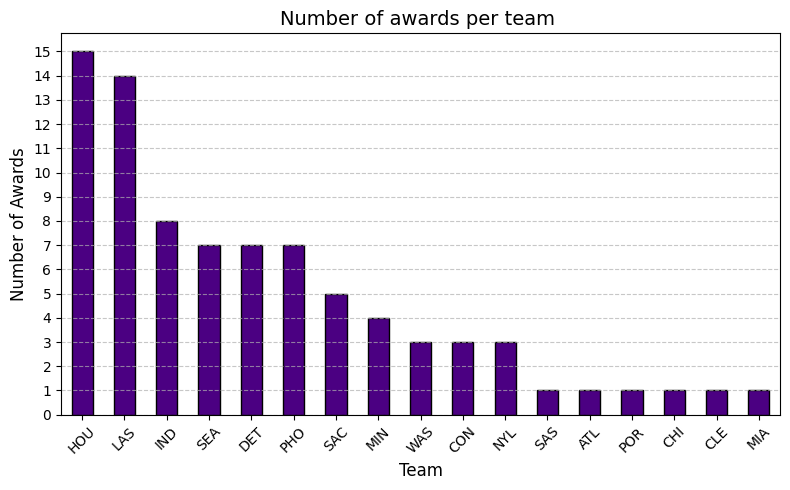

In [299]:
merged_df = pd.merge(players_teams, awards_players, on=['playerID', 'year'], how='inner')

awards_counts = merged_df.groupby('tmID')['award'].count()
awards_counts = awards_counts.sort_values(ascending=False)

plt.figure(figsize=(8, 5))
awards_counts.plot(kind='bar', color='indigo', edgecolor='black')

max_award = awards_counts.max()
plt.yticks(range(0, max_award+1, 1))

plt.title('Number of awards per team ', fontsize=14)
plt.xlabel('Team', fontsize=12)
plt.ylabel('Number of Awards', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

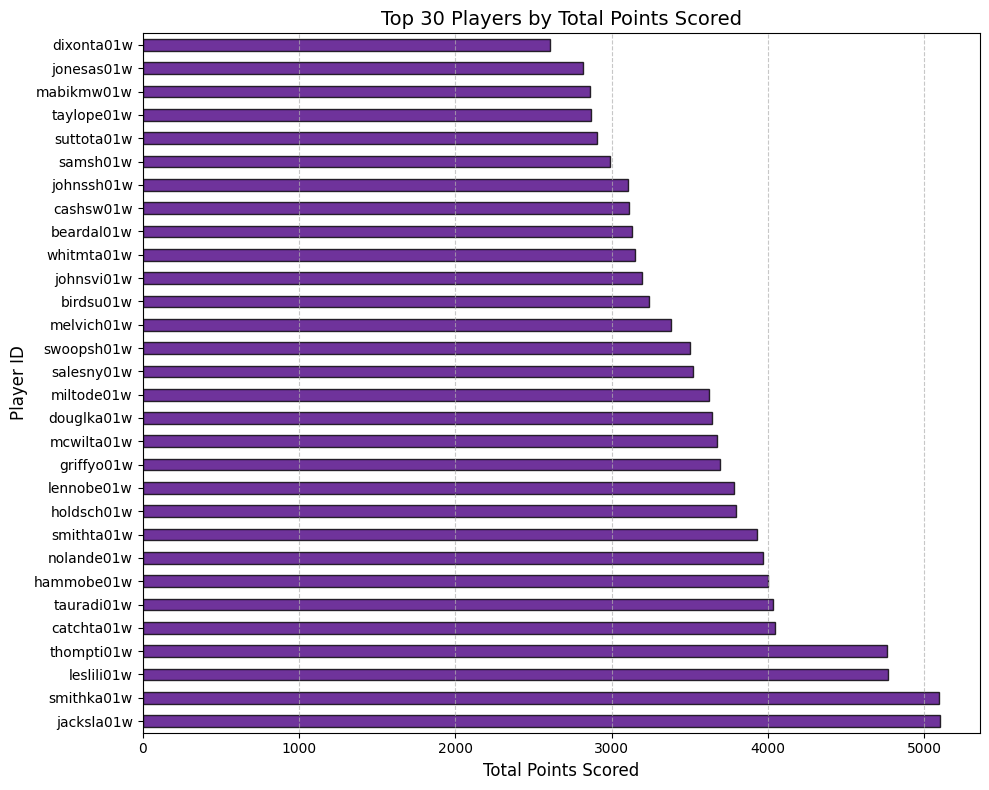

In [300]:
merged_df = pd.merge(players_teams, teams, on=['tmID', 'year'], how='inner')

sumpoints = merged_df.groupby('playerID')['points'].sum().sort_values(ascending=False)

top_30_points = sumpoints.head(30)

plt.figure(figsize=(10, 8))

top_30_points.plot(kind='barh', color='indigo', edgecolor='black', alpha=0.8)

plt.title('Top 30 Players by Total Points Scored', fontsize=14)
plt.xlabel('Total Points Scored', fontsize=12)
plt.ylabel('Player ID', fontsize=12)

plt.yticks(fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

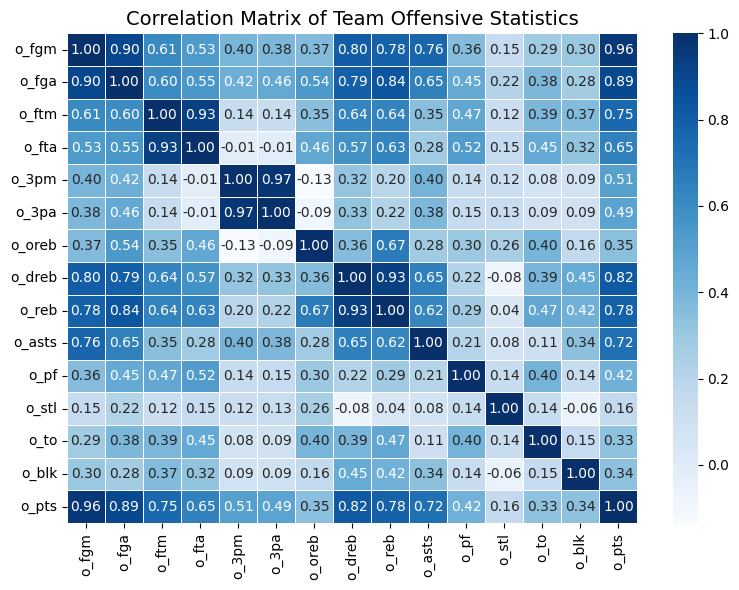

In [301]:
df = teams.copy()


df_numeric = df.filter(like='o_', axis=1)

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Team Offensive Statistics', fontsize=14)
plt.tight_layout()
plt.show()

# Data Preparation


In [302]:
awards_players = pd.read_csv('awards_players.csv')
coaches = pd.read_csv('coaches.csv')
players = pd.read_csv('players.csv')
players_teams = pd.read_csv('players_teams.csv')
series_post = pd.read_csv('series_post.csv')
teams = pd.read_csv('teams.csv')
teams_post = pd.read_csv('teams_post.csv')

In [303]:
# Drop unnecessary columns only after all calculations are done
players.drop(['firstseason', 'lastseason','deathDate','collegeOther'], axis=1, inplace=True)
players.head()

,bioID,pos,height,weight,college,birthDate
0,abrahta01w,C,74.0,190,George Washington,1975-09-27
1,abrossv01w,F,74.0,169,Connecticut,1980-07-09
2,adairje01w,C,76.0,197,George Washington,1986-12-19
3,adamsda01w,F-C,73.0,239,Texas A&M,1989-02-19
4,adamsjo01w,C,75.0,180,New Mexico,1981-05-24


In [304]:
# Teams
# 1. Win Ratios
teams['win_ratio'] = teams['won'] / teams['GP']
teams.drop(['won'], axis=1, inplace=True)

teams['home_win_ratio'] = teams['homeW'] / (teams['homeW'] + teams['homeL'])
teams.drop(['homeW', 'homeL'], axis=1, inplace=True)

teams['away_win_ratio'] = teams['awayW'] / (teams['awayW'] + teams['awayL'])
teams.drop(['awayW', 'awayL'], axis=1, inplace=True)

teams['conf_win_ratio'] = teams['confW'] / (teams['confW'] + teams['confL'])
teams.drop(['confW', 'confL'], axis=1, inplace=True)

# 2. Scoring Efficiency
teams['off_efficiency'] = teams['o_pts'] / (teams['o_fga'] + teams['o_fta'])
teams.drop(['o_pts', 'o_fga', 'o_fta'], axis=1, inplace=True)

teams['def_efficiency'] = teams['d_pts'] / (teams['d_fga'] + teams['d_fta'])
teams.drop(['d_pts', 'd_fga', 'd_fta'], axis=1, inplace=True)

# 3. Rebounding Metrics
teams['off_reb_percentage'] = teams['o_oreb'] / (teams['o_oreb'] + teams['d_dreb'])
teams.drop(['o_oreb', 'd_dreb'], axis=1, inplace=True)

teams['def_reb_percentage'] = teams['o_dreb'] / (teams['o_dreb'] + teams['d_oreb'])
teams.drop(['o_dreb', 'd_oreb'], axis=1, inplace=True)

# 4. Turnover Ratio
teams['to_ratio'] = teams['o_to'] / teams['GP']

# Assuming the dataframe is named `teams`

# 1. Scoring Contribution
teams['fgm_contribution'] = teams['o_fgm'] * 2 + teams['o_3pm'] * 3
teams['ftm_contribution'] = teams['o_ftm']  # Free throws worth 1 point each
teams['three_point_ratio'] = teams['o_3pm'] / teams['o_3pa']

# Drop the columns used above
teams.drop(['o_fgm', 'o_3pm', 'o_ftm', 'o_3pa'], axis=1, inplace=True)

# 3. Assist-to-Turnover Ratios
teams['off_ast_to_ratio'] = teams['o_asts'] / teams['o_to']
teams['def_ast_to_ratio'] = teams['d_asts'] / teams['d_to']

# Drop assist and turnover columns
teams.drop(['o_asts', 'd_asts', 'o_to', 'd_to'], axis=1, inplace=True)

# 4. Steal and Block Ratios
teams['off_steal_ratio'] = teams['o_stl'] / teams['GP']
teams['off_block_ratio'] = teams['o_blk'] / teams['GP']
teams['def_steal_ratio'] = teams['d_stl'] / teams['GP']
teams['def_block_ratio'] = teams['d_blk'] / teams['GP']

# Drop the corresponding columns
teams.drop(['o_stl', 'o_blk', 'd_stl', 'd_blk'], axis=1, inplace=True)

# 5. Efficiency per Minute
teams['efficiency_per_min'] = (teams['win_ratio'] + teams['off_efficiency'] - teams['def_efficiency']) / teams['min']

# Drop the `min` column as it's been used
teams.drop(['min'], axis=1, inplace=True)

# 6. Points allowed vs. Points scored
teams['points_diff'] = (teams['win_ratio'] * teams['GP'] * teams['off_efficiency']) - (teams['def_efficiency'] * teams['GP'] * teams['win_ratio'])

teams['playoff'] = teams['rank'] <= 4

teams_filtered = teams[teams['year'] <= 8] # avoid data leak, year 9 is test
teams['playoffratio'] = teams_filtered.groupby('tmID')['playoff'].transform('mean')
teams['meanrank'] = teams_filtered.groupby('tmID')['rank'].transform('mean')


# Drop any other residual columns
# DivID, seeded,'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'  are always nan or 0
# arena and name are irrelevant
# lgID is alaway the same WNBA
# 'firstRound','semis', 'finals' to prevent future data leakage
teams.drop(['tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB','d_fgm', 'd_ftm', 'd_3pm', 'd_3pa', 'o_reb', 'd_reb', 'o_pf', 'd_pf', 'lost','divID','arena','lgID','name','seeded','firstRound','semis', 'finals'], axis=1, inplace=True)


In [305]:
teams.head()

,year,tmID,franchID,confID,rank,playoff,GP,attend,win_ratio,home_win_ratio,...,off_ast_to_ratio,def_ast_to_ratio,off_steal_ratio,off_block_ratio,def_steal_ratio,def_block_ratio,efficiency_per_min,points_diff,playoffratio,meanrank
0,9,ATL,ATL,EA,7,False,34,141379,0.117647,0.058824,...,0.829680,1.219251,8.382353,4.176471,9.117647,3.941176,0.000009,-0.232595,NaN,NaN
1,10,ATL,ATL,EA,2,True,34,120737,0.529412,0.705882,...,0.927119,1.023295,9.676471,3.558824,10.205882,3.911765,0.000079,0.297057,NaN,NaN
2,1,CHA,CHA,EA,8,False,32,90963,0.250000,0.312500,...,1.110887,1.399061,6.937500,2.812500,8.093750,3.843750,0.000033,-0.292302,0.428571,4.714286
3,2,CHA,CHA,EA,4,True,32,105525,0.562500,0.687500,...,0.985232,0.991051,6.781250,3.562500,8.031250,3.875000,0.000095,1.009421,0.428571,4.714286
4,3,CHA,CHA,EA,2,True,32,106670,0.562500,0.687500,...,1.215686,1.153302,7.531250,3.281250,6.500000,3.218750,0.000091,0.480113,0.428571,4.714286


In [306]:
# Use `teams_post` dataframe for augmentation
# 1. Win Ratio
teams_post['win_ratio_post'] = teams_post['W'] / (teams_post['W'] + teams_post['L'])

# 2. Total Games Played
teams_post['total_games_post'] = teams_post['W'] + teams_post['L']

# 3. Winning Margin
teams_post['win_margin_post'] = teams_post['W'] - teams_post['L']

# Drop the columns used for calculations
teams_post.drop(['W', 'L','lgID'], axis=1, inplace=True)
teams_post.fillna(0, inplace=True)

In [307]:
# Use `players_teams` dataframe for augmentation

# 1. Per-Game Metrics
players_teams['points_per_game'] = players_teams['points'] / players_teams['GP']
players_teams['rebounds_per_game'] = (players_teams['oRebounds'] + players_teams['dRebounds']) / players_teams['GP']
players_teams['assists_per_game'] = players_teams['assists'] / players_teams['GP']
players_teams['steals_per_game'] = players_teams['steals'] / players_teams['GP']
players_teams['blocks_per_game'] = players_teams['blocks'] / players_teams['GP']

# Drop columns used for the above calculations
players_teams.drop(['points', 'oRebounds', 'dRebounds', 'assists', 'steals', 'blocks'], axis=1, inplace=True)

# 2. Efficiency Ratios
players_teams['assist_to_turnover_ratio'] = players_teams['assists_per_game'] / players_teams['turnovers']
players_teams['points_per_minute'] = players_teams['points_per_game'] / players_teams['minutes']

# Drop the `turnovers` column
players_teams.drop(['turnovers'], axis=1, inplace=True)

# 3. Postseason Metrics (mirror regular season)
players_teams['post_points_per_game'] = players_teams['PostPoints'] / players_teams['PostGP']
players_teams['post_rebounds_per_game'] = (players_teams['PostoRebounds'] + players_teams['PostdRebounds']) / players_teams['PostGP']
players_teams['post_assists_per_game'] = players_teams['PostAssists'] / players_teams['PostGP']

# Drop the postseason columns used
players_teams.drop(['PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostAssists'], axis=1, inplace=True)

# 4. Player Impact Score
players_teams['player_impact_score'] = (players_teams['points_per_game'] + players_teams['rebounds_per_game'] +
                                        players_teams['assists_per_game'] + players_teams['steals_per_game'] * 2)

# 1. Shooting Efficiency Metrics
players_teams['fg_percentage'] = players_teams['fgMade'] / players_teams['fgAttempted']
players_teams['ft_percentage'] = players_teams['ftMade'] / players_teams['ftAttempted']
players_teams['three_point_percentage'] = players_teams['threeMade'] / players_teams['threeAttempted']

# Drop columns used above
players_teams.drop(['fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade'], axis=1, inplace=True)

# 2. Fouls and Discipline Metrics
# Use `GP` before dropping it
players_teams['foul_rate'] = players_teams['PF'] / players_teams['GP']
players_teams['disqualification_rate'] = players_teams['dq'] / players_teams['GP']

# Drop columns used above
players_teams.drop(['PF', 'dq'], axis=1, inplace=True)

# 3. Postseason Shooting Efficiency
players_teams['post_fg_percentage'] = players_teams['PostfgMade'] / players_teams['PostfgAttempted']
players_teams['post_ft_percentage'] = players_teams['PostftMade'] / players_teams['PostftAttempted']
players_teams['post_three_point_percentage'] = players_teams['PostthreeMade'] / players_teams['PostthreeAttempted']

# Drop postseason shooting columns used
players_teams.drop(['PostfgAttempted', 'PostfgMade', 'PostftAttempted', 'PostftMade',
                    'PostthreeAttempted', 'PostthreeMade'], axis=1, inplace=True)

# 4. Postseason Impact Metrics
# Use `PostGP` before dropping it
players_teams['post_rebounds_per_game'] = players_teams['PostRebounds'] / players_teams['PostGP']
players_teams['post_steals_per_game'] = players_teams['PostSteals'] / players_teams['PostGP']
players_teams['post_blocks_per_game'] = players_teams['PostBlocks'] / players_teams['PostGP']
players_teams['post_turnover_rate'] = players_teams['PostTurnovers'] / players_teams['PostGP']
players_teams['post_foul_rate'] = players_teams['PostPF'] / players_teams['PostGP']
players_teams['post_disqualification_rate'] = players_teams['PostDQ'] / players_teams['PostGP']
#players_teams['pplayoff'] = players_teams['PostGP'] > 0

# Calculer le pourcentage d'années où le rang est <= 4 pour chaque équipe
#players_teams['pplayoffratio'] = players_teams.groupby('playerID')['pplayoff'].transform('mean')

# Drop the GP columns only after they have been used
players_teams.drop(['PostGP', 'minutes', 'GP', 'GS', 'PostRebounds', 'PostSteals', 'PostBlocks',
                    'PostTurnovers', 'PostPF', 'PostDQ', 'PostGS', 'PostMinutes','lgID'], axis=1, inplace=True)

players_teams.fillna(0, inplace=True)

In [308]:
players_teams.head()

,playerID,year,stint,tmID,rebounds,points_per_game,rebounds_per_game,assists_per_game,steals_per_game,blocks_per_game,...,foul_rate,disqualification_rate,post_fg_percentage,post_ft_percentage,post_three_point_percentage,post_steals_per_game,post_blocks_per_game,post_turnover_rate,post_foul_rate,post_disqualification_rate
0,abrossv01w,2,0,MIN,174,13.192308,6.692308,2.038462,1.615385,0.346154,...,2.692308,0.076923,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,abrossv01w,3,0,MIN,146,11.629630,5.407407,2.222222,1.555556,0.370370,...,2.703704,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,abrossv01w,4,0,MIN,141,10.600000,4.700000,2.733333,1.466667,0.366667,...,2.633333,0.000000,0.272727,1.0,0.428571,1.333333,0.333333,2.666667,2.666667,0.0
3,abrossv01w,5,0,MIN,74,6.636364,3.363636,2.045455,1.363636,0.090909,...,1.909091,0.000000,0.347826,0.5,0.250000,0.500000,1.000000,1.500000,3.500000,0.0
4,abrossv01w,6,0,MIN,107,9.806452,3.451613,1.935484,1.548387,0.193548,...,2.774194,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [309]:
# Use `coaches` dataframe for augmentation

# 1. Win Ratios
coaches['win_ratio'] = coaches['won'] / (coaches['won'] + coaches['lost'])
coaches['post_win_ratio'] = coaches['post_wins'] / (coaches['post_wins'] + coaches['post_losses'])

# 2. Total Games Coached
coaches['total_games'] = coaches['won'] + coaches['lost']
coaches['total_post_games'] = coaches['post_wins'] + coaches['post_losses']

# Drop the original columns used for calculations
coaches.drop(['won', 'lost', 'post_wins', 'post_losses','lgID'], axis=1, inplace=True)
coaches.fillna(0, inplace=True)

coaches['playoff'] = coaches['total_post_games'] > 0

coaches_filtered = coaches[coaches['year'] <= 8]

coaches['playoffratio'] = coaches_filtered.groupby('coachID')['playoff'].transform('mean')


In [310]:
awards_players['award'].unique()

array(['All-Star Game Most Valuable Player', 'Coach of the Year',
       'Defensive Player of the Year', 'Kim Perrot Sportsmanship',
       'Kim Perrot Sportsmanship Award', 'Most Improved Player',
       'Most Valuable Player', 'Rookie of the Year',
       'Sixth Woman of the Year', 'WNBA Finals Most Valuable Player',
       'WNBA All-Decade Team', 'WNBA All Decade Team Honorable Mention'],
      dtype=object)

In [311]:
awards_players.loc[awards_players['award'] == 'Kim Perrot Sportsmanship', 'award'] = 'Kim Perrot Sportsmanship Award' #They are the same

In [312]:
#Define a mapping dictionary for awards and their respective points
award_points_mapping = {
    'Kim Perrot Sportsmanship Award': 0,
    'Most Valuable Player': 15,
    'WNBA Finals Most Valuable Player': 13,
    'WNBA All-Decade Team': 12,
    'All-Star Game Most Valuable Player': 10,
    'Coach of the Year': 9,
    'Defensive Player of the Year': 8,
    'WNBA All Decade Team Honorable Mention': 7,
    'Sixth Woman of the Year': 6,
    'Most Improved Player': 5,
    'Rookie of the Year': 4
}

# Map the 'award' column to the points using the mapping dictionary
awards_players['awardPoints'] = awards_players['award'].map(award_points_mapping)
awards_players.drop(['award'], axis=1, inplace=True)

In [313]:
awards_players.head()

,playerID,year,lgID,awardPoints
0,thompti01w,1,WNBA,10
1,leslili01w,2,WNBA,10
2,leslili01w,3,WNBA,10
3,teaslni01w,4,WNBA,10
4,swoopsh01w,6,WNBA,10


In [314]:
# Correct the prefix handling and ensure 'playerID' is retained correctly

coaches_prefixed = coaches.add_prefix('coaches_')
players_prefixed = players.add_prefix('players_')
players_teams_prefixed = players_teams.add_prefix('players_teams_')
teams_prefixed = teams.add_prefix('teams_')
teams_post_prefixed = teams_post.add_prefix('teams_post_')
awards_players_prefixed = awards_players.add_prefix('awards_players_')

# Remove the prefix from columns used for merging
teams_prefixed.rename(columns={'teams_tmID': 'tmID', 'teams_year': 'year'}, inplace=True)
teams_post_prefixed.rename(columns={'teams_post_tmID': 'tmID', 'teams_post_year': 'year'}, inplace=True)
coaches_prefixed.rename(columns={'coaches_tmID': 'tmID', 'coaches_year': 'year'}, inplace=True)
players_teams_prefixed.rename(columns={'players_teams_tmID': 'tmID', 'players_teams_year': 'year', 'players_teams_playerID': 'playerID'}, inplace=True)
awards_players_prefixed.rename(columns={'awards_players_playerID': 'playerID', 'awards_players_year': 'year'}, inplace=True)

# Step 2: Merge teams with teams_post
team_data = pd.merge(teams_prefixed, teams_post_prefixed, how='left', on=['tmID', 'year'])

# Step 3: Merge players with players_teams
players_prefixed.rename(columns={'players_bioID': 'playerID'}, inplace=True)
players_prefixed.rename(columns={'players_playerID': 'playerID'}, inplace=True)

# Step 3: Merge players with players_teams correctly using the right columns
players_teams_combined = pd.merge(players_teams_prefixed, players_prefixed, how='left', on='playerID')

def classify_position(position):
    interior = ['C', 'CF', 'FC']
    if position in interior:
        return 'interior'
    else:
        return 'exterior'

players_teams_combined['players_pos'] = players_teams_combined['players_pos'].apply(classify_position)

players_teams_combined['players_birthDate'] = pd.to_datetime(players_teams_combined['players_birthDate'])

players_teams_combined['offset'] = players_teams_combined['players_birthDate'].dt.year - 1978

result = players_teams_combined.groupby(['tmID', 'year']).agg(
    num_interior=('players_pos', lambda x: (x == 'interior').sum()),
    num_exterior=('players_pos', lambda x: (x == 'exterior').sum())
).reset_index()  #this table result contain tmid year the number of interior player and number of exterior player


# Continue with the rest of the merge steps as defined
# Step 4: Aggregate player stats by team
player_stats_by_team = players_teams_combined.groupby(['tmID', 'year']).agg({
    'players_teams_points_per_game': 'sum',
    'players_teams_rebounds_per_game': 'sum',
    'offset':'mean'#,'players_teams_pplayoffratio': 'max'
}).reset_index()

# Step 5: Merge team_data with player_stats_by_team
team_data = pd.merge(team_data, player_stats_by_team, how='left', on=['tmID', 'year'])
team_data = pd.merge(team_data, result, how='left', on=['tmID', 'year'])
# Step 6.0 Aggregate coaches stats by teal
coaches_agg = coaches_prefixed.groupby(['tmID', 'year']).agg({
    'coaches_stint': 'sum',                   # Somme des périodes de coaching (passages)
    'coaches_win_ratio': 'mean',              # Moyenne du ratio de victoires
    'coaches_post_win_ratio': 'mean',         # Moyenne du ratio de victoires en playoffs
    'coaches_total_games': 'sum',             # Somme du nombre total de matchs joués
    'coaches_total_post_games': 'sum',       # Somme du nombre total de matchs en playoffs
    'coaches_playoffratio' : 'mean'
}).reset_index()

# Merge team_data with coaches
team_data = pd.merge(team_data, coaches_agg, how='left', on=['tmID', 'year'])

# Step 6: Merge team_data with coaches
#team_data = pd.merge(team_data, coaches_prefixed, how='left', on=['tmID', 'year']) old version dont use it

# Step 7: Merge awards_players with players_teams
awards_with_teams = pd.merge(awards_players_prefixed, players_teams_prefixed, how='left', on=['playerID', 'year'])

# Step 8: Aggregate awards by team
awards_by_team = awards_with_teams.groupby(['tmID', 'year']).agg({
    'awards_players_awardPoints': 'sum'
}).reset_index()

# Step 9: Merge awards_by_team with team_data
team_data = pd.merge(team_data, awards_by_team, how='left', on=['tmID', 'year'])

# Step 10: Fill missing values in num_awards and other columns
team_data['awards_players_awardPoints'].fillna(0, inplace=True)
team_data.fillna(0, inplace=True)

<ipython-input-314-72378622008e>:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  team_data['awards_players_awardPoints'].fillna(0, inplace=True)


In [315]:
players_teams_combined.head()

,playerID,year,players_teams_stint,tmID,players_teams_rebounds,players_teams_points_per_game,players_teams_rebounds_per_game,players_teams_assists_per_game,players_teams_steals_per_game,players_teams_blocks_per_game,...,players_teams_post_blocks_per_game,players_teams_post_turnover_rate,players_teams_post_foul_rate,players_teams_post_disqualification_rate,players_pos,players_height,players_weight,players_college,players_birthDate,offset
0,abrossv01w,2,0,MIN,174,13.192308,6.692308,2.038462,1.615385,0.346154,...,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
1,abrossv01w,3,0,MIN,146,11.629630,5.407407,2.222222,1.555556,0.370370,...,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
2,abrossv01w,4,0,MIN,141,10.600000,4.700000,2.733333,1.466667,0.366667,...,0.333333,2.666667,2.666667,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
3,abrossv01w,5,0,MIN,74,6.636364,3.363636,2.045455,1.363636,0.090909,...,1.000000,1.500000,3.500000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
4,abrossv01w,6,0,MIN,107,9.806452,3.451613,1.935484,1.548387,0.193548,...,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2


In [316]:
players_teams_combined.head()

,playerID,year,players_teams_stint,tmID,players_teams_rebounds,players_teams_points_per_game,players_teams_rebounds_per_game,players_teams_assists_per_game,players_teams_steals_per_game,players_teams_blocks_per_game,...,players_teams_post_blocks_per_game,players_teams_post_turnover_rate,players_teams_post_foul_rate,players_teams_post_disqualification_rate,players_pos,players_height,players_weight,players_college,players_birthDate,offset
0,abrossv01w,2,0,MIN,174,13.192308,6.692308,2.038462,1.615385,0.346154,...,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
1,abrossv01w,3,0,MIN,146,11.629630,5.407407,2.222222,1.555556,0.370370,...,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
2,abrossv01w,4,0,MIN,141,10.600000,4.700000,2.733333,1.466667,0.366667,...,0.333333,2.666667,2.666667,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
3,abrossv01w,5,0,MIN,74,6.636364,3.363636,2.045455,1.363636,0.090909,...,1.000000,1.500000,3.500000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2
4,abrossv01w,6,0,MIN,107,9.806452,3.451613,1.935484,1.548387,0.193548,...,0.000000,0.000000,0.000000,0.0,exterior,74.0,169,Connecticut,1980-07-09,2


In [317]:
team_data.head()

,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,teams_home_win_ratio,...,offset,num_interior,num_exterior,coaches_stint,coaches_win_ratio,coaches_post_win_ratio,coaches_total_games,coaches_total_post_games,coaches_playoffratio,awards_players_awardPoints
0,9,ATL,ATL,EA,7,False,34,141379,0.117647,0.058824,...,4.428571,1,13,0,0.117647,0.0,34,0,0.00,0.0
1,10,ATL,ATL,EA,2,True,34,120737,0.529412,0.705882,...,4.384615,1,12,0,0.529412,0.0,34,2,0.00,4.0
2,1,CHA,CHA,EA,8,False,32,90963,0.250000,0.312500,...,-4.538462,2,11,0,0.250000,0.0,32,0,0.00,0.0
3,2,CHA,CHA,EA,4,True,32,105525,0.562500,0.687500,...,-3.750000,2,10,0,0.562500,0.5,32,8,0.75,0.0
4,3,CHA,CHA,EA,2,True,32,106670,0.562500,0.687500,...,-3.769231,3,10,0,0.562500,0.0,32,2,0.75,0.0


In [318]:
team_data.columns

Index(['year', 'tmID', 'teams_franchID', 'teams_confID', 'teams_rank',
       'teams_playoff', 'teams_GP', 'teams_attend', 'teams_win_ratio',
       'teams_home_win_ratio', 'teams_away_win_ratio', 'teams_conf_win_ratio',
       'teams_off_efficiency', 'teams_def_efficiency',
       'teams_off_reb_percentage', 'teams_def_reb_percentage',
       'teams_to_ratio', 'teams_fgm_contribution', 'teams_ftm_contribution',
       'teams_three_point_ratio', 'teams_off_ast_to_ratio',
       'teams_def_ast_to_ratio', 'teams_off_steal_ratio',
       'teams_off_block_ratio', 'teams_def_steal_ratio',
       'teams_def_block_ratio', 'teams_efficiency_per_min',
       'teams_points_diff', 'teams_playoffratio', 'teams_meanrank',
       'teams_post_win_ratio_post', 'teams_post_total_games_post',
       'teams_post_win_margin_post', 'players_teams_points_per_game',
       'players_teams_rebounds_per_game', 'offset', 'num_interior',
       'num_exterior', 'coaches_stint', 'coaches_win_ratio',
       'coaches

In [319]:
team_data_no_str = team_data.drop(['tmID', 'teams_franchID', 'teams_confID','teams_playoff'], axis=1)

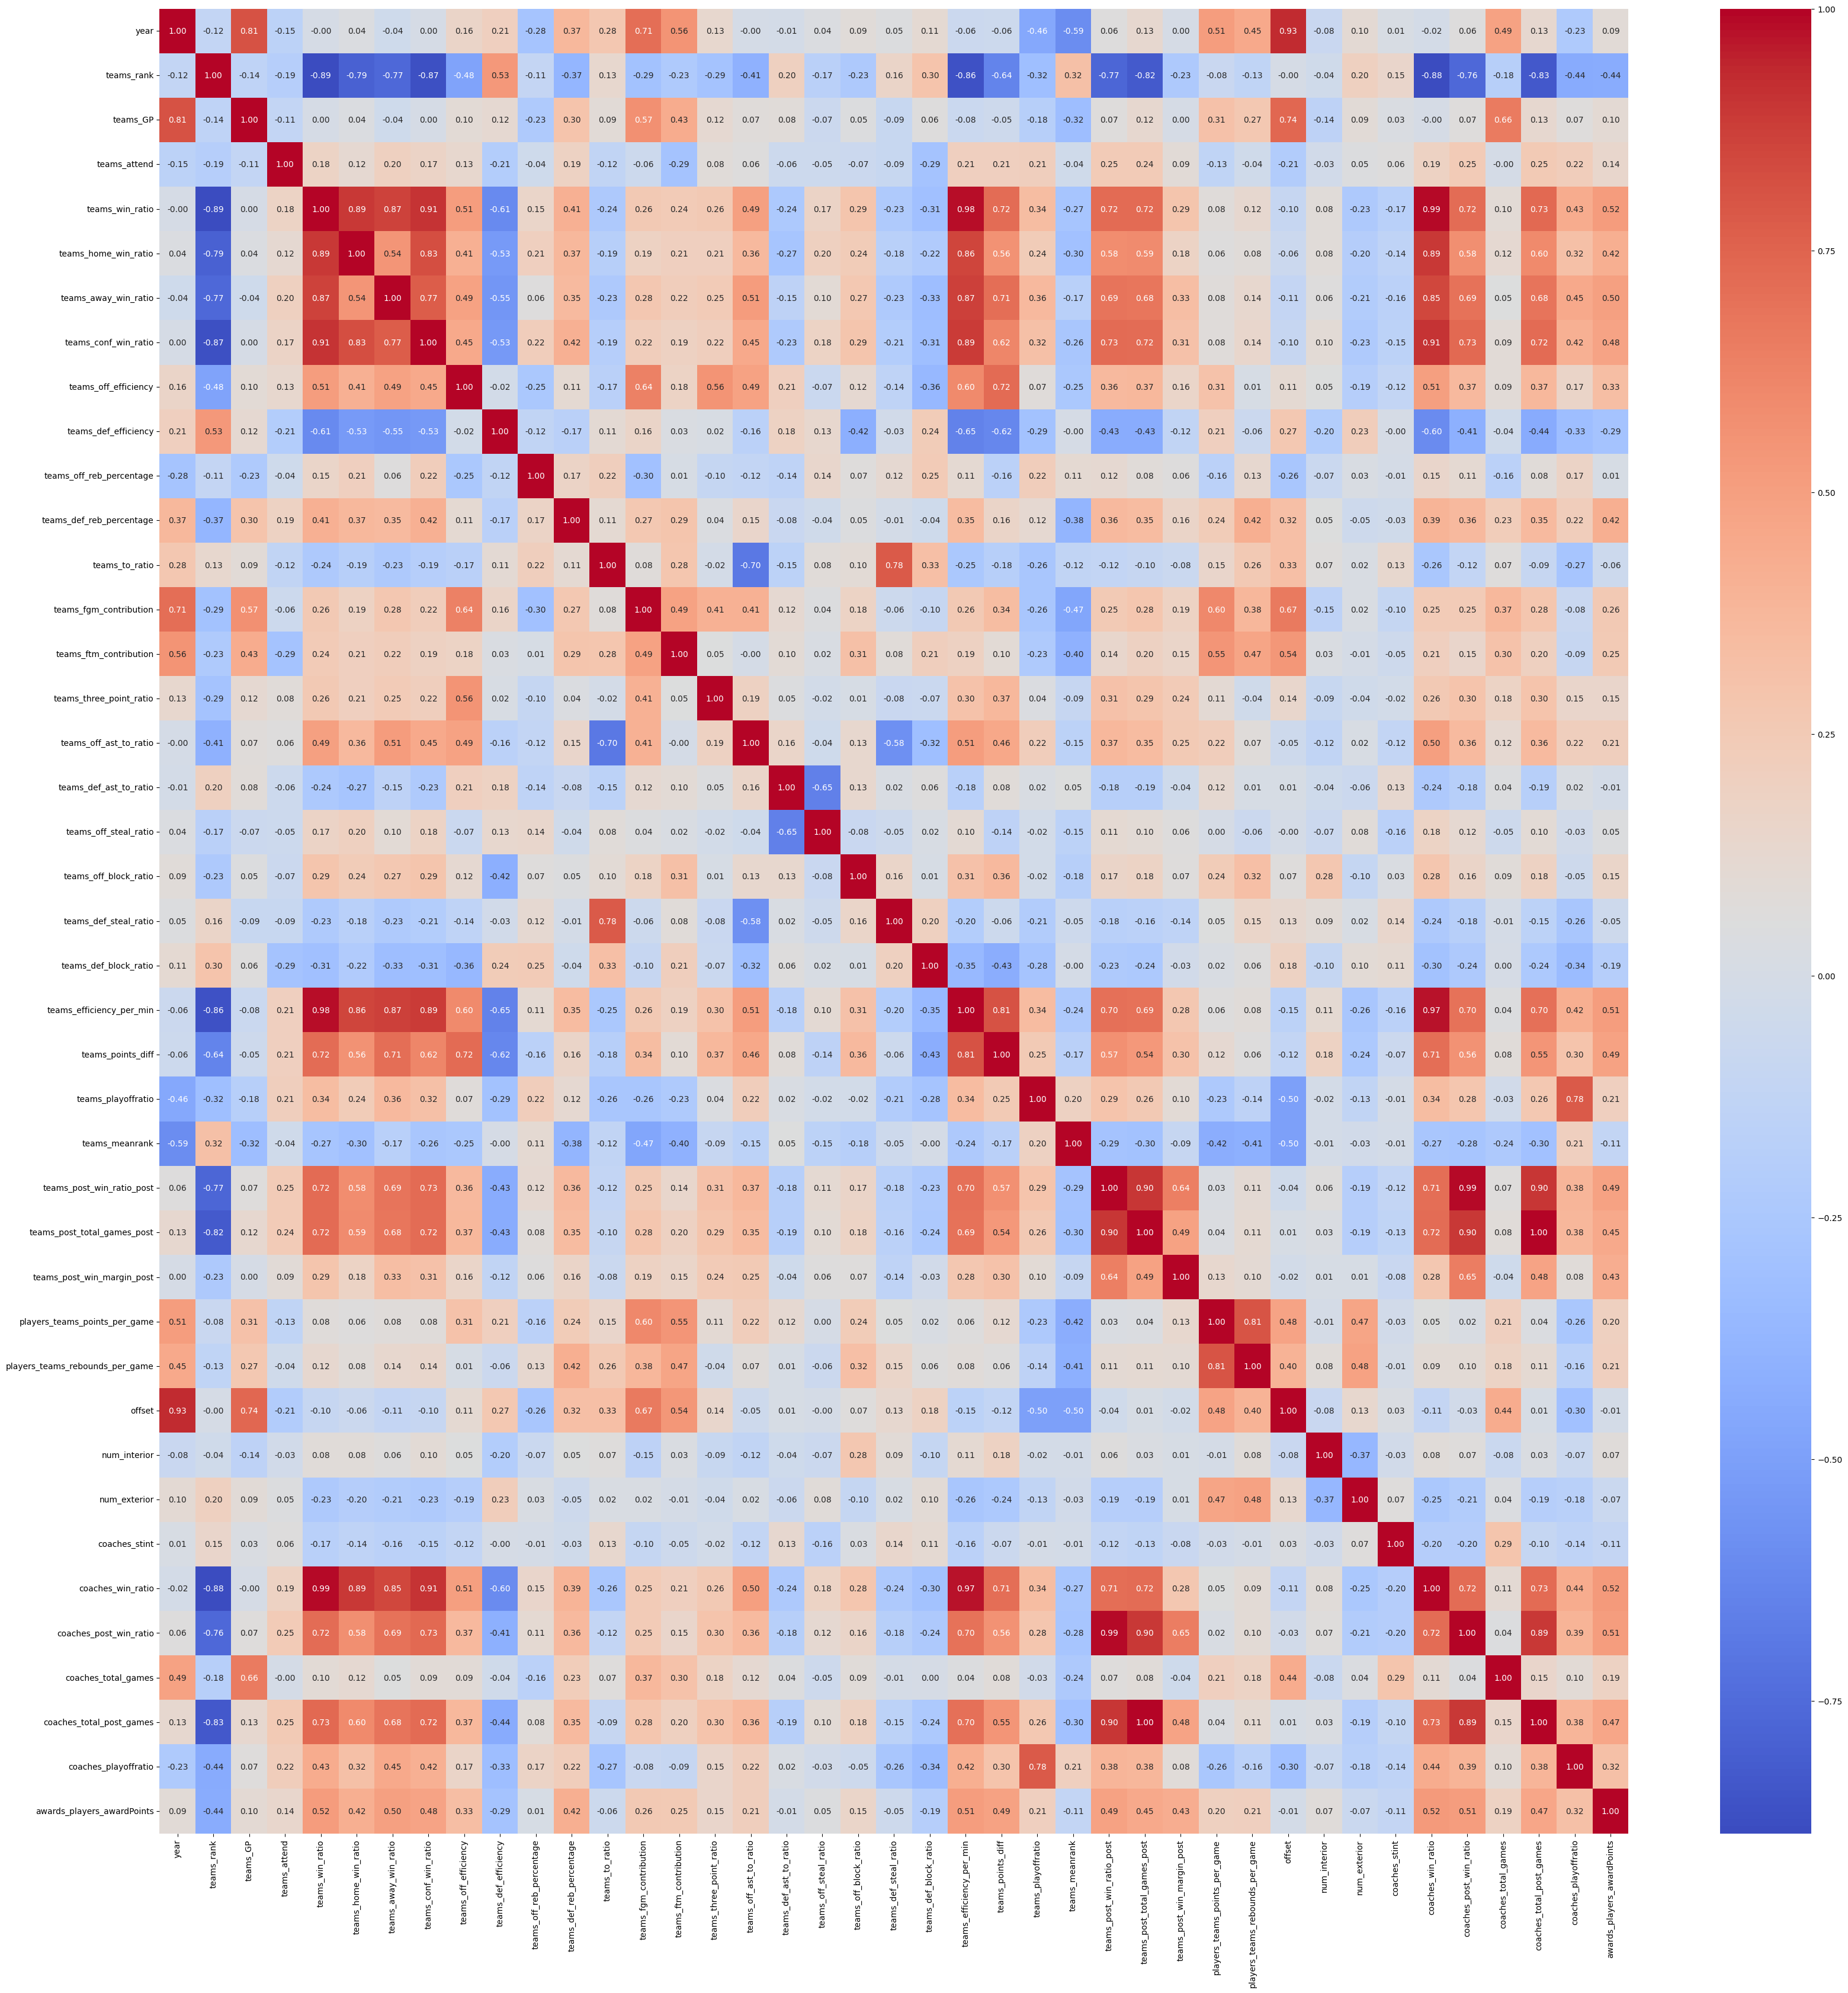

In [320]:
# Calculate the correlation matrix
corr_matrix = team_data_no_str.corr()

# Save the correlation matrix as a CSV file
corr_matrix.to_csv("correlation_matrix.csv")

# Plot heatmap for correlation
plt.figure(figsize=(40,40))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [321]:
# Find columns with high correlation (|correlation| >= 0.75) to determine which to drop
columns_to_drop = set()

# Iterate through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 0.90:
            # Drop the second column in the highly correlated pair
            col2 = corr_matrix.columns[j]
            columns_to_drop.add(col2)

# Create a reduced dataframe by dropping these columns
reduced_data = team_data.drop(columns=list(columns_to_drop))

# Generate new interaction terms for remaining columns
# Select numerical columns for interaction term creation
remaining_numerical_columns = reduced_data.select_dtypes(include=[np.number]).columns

print(columns_to_drop)

{'offset', 'coaches_total_post_games', 'teams_post_total_games_post', 'teams_conf_win_ratio', 'coaches_post_win_ratio', 'teams_efficiency_per_min', 'coaches_win_ratio'}


In [322]:
reduced_data.head()

,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,teams_home_win_ratio,...,teams_post_win_ratio_post,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,num_interior,num_exterior,coaches_stint,coaches_total_games,coaches_playoffratio,awards_players_awardPoints
0,9,ATL,ATL,EA,7,False,34,141379,0.117647,0.058824,...,0.0,0.0,90.280886,42.711812,1,13,0,34,0.00,0.0
1,10,ATL,ATL,EA,2,True,34,120737,0.529412,0.705882,...,0.0,-2.0,95.379269,41.553204,1,12,0,34,0.00,4.0
2,1,CHA,CHA,EA,8,False,32,90963,0.250000,0.312500,...,0.0,0.0,83.889925,34.508183,2,11,0,32,0.00,0.0
3,2,CHA,CHA,EA,4,True,32,105525,0.562500,0.687500,...,0.5,0.0,68.969460,34.470022,2,10,0,32,0.75,0.0
4,3,CHA,CHA,EA,2,True,32,106670,0.562500,0.687500,...,0.0,-2.0,74.023695,32.655009,3,10,0,32,0.75,0.0


In [323]:
# Step 1: Sort the data by team ID and year
reduced_data_sorted = reduced_data.sort_values(by=['tmID', 'year'])

# Step 2: Shift the `teams_playoff_Y` column by -1 year within each team group
reduced_data_sorted['next_season_playoff'] = reduced_data_sorted.groupby('tmID')['teams_playoff'].shift(-1)

# Sort data by `year` and `tmID`
reduced_data_sorted['teams_playoff'] = reduced_data_sorted['teams_playoff'].map({True: 1, False: 0}).fillna(0).astype(int)

reduced_data_sorted['next_season_playoff'] = reduced_data_sorted['next_season_playoff'].map({True: 1, False: 0}).fillna(0).astype(int)
# Initialize an empty list to store predictions and corresponding years
all_predictions = []
all_actuals = []

# List of years in the dataset
years = reduced_data_sorted['year'].unique()

In [324]:
reduced_data_sorted.head()

,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,teams_home_win_ratio,...,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,num_interior,num_exterior,coaches_stint,coaches_total_games,coaches_playoffratio,awards_players_awardPoints,next_season_playoff
0,9,ATL,ATL,EA,7,0,34,141379,0.117647,0.058824,...,0.0,90.280886,42.711812,1,13,0,34,0.00,0.0,1
1,10,ATL,ATL,EA,2,1,34,120737,0.529412,0.705882,...,-2.0,95.379269,41.553204,1,12,0,34,0.00,4.0,0
2,1,CHA,CHA,EA,8,0,32,90963,0.250000,0.312500,...,0.0,83.889925,34.508183,2,11,0,32,0.00,0.0,1
3,2,CHA,CHA,EA,4,1,32,105525,0.562500,0.687500,...,0.0,68.969460,34.470022,2,10,0,32,0.75,0.0,1
4,3,CHA,CHA,EA,2,1,32,106670,0.562500,0.687500,...,-2.0,74.023695,32.655009,3,10,0,32,0.75,0.0,1


In [325]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.models import ColumnDataSource
from bokeh.palettes import Blues8

output_notebook()

reduced_data_no_str = reduced_data_sorted.drop(['tmID', 'teams_franchID', 'teams_confID'], axis=1)

correlation_with_target = reduced_data_no_str.corr(method='spearman')['next_season_playoff'].drop('next_season_playoff').sort_values(ascending=False)

features = correlation_with_target.index.tolist()
correlation_values = correlation_with_target.values
source = ColumnDataSource(data=dict(features=features, correlation=correlation_values))

p = figure(x_range=features, height=400, width=800, title="Correlation of Features with Target",
           toolbar_location=None, tools="")

p.vbar(x='features', top='correlation', width=0.8, source=source,
       fill_color=factor_cmap('features', palette=Blues8, factors=features))

p.xgrid.grid_line_color = None
p.y_range.start = -1  # correlation between -1 and 1
p.xaxis.major_label_orientation = 1.2
p.xaxis.axis_label = "Features"
p.yaxis.axis_label = "Correlation"

show(p)



In [326]:
# Remove last year played for each team because we dont have the target in this case (next season playoff)
indexes_to_drop = []

teams = reduced_data_sorted['tmID'].unique()

for team in teams:
    team_data = reduced_data_sorted[reduced_data_sorted['tmID'] == team]

    max_year = team_data['year'].max()

    index_to_drop = team_data[team_data['year'] == max_year].index

    indexes_to_drop.extend(index_to_drop)

filtered_data = reduced_data_sorted.drop(indexes_to_drop).reset_index(drop=True)


filtered_data = filtered_data.reset_index(drop=True)

train = filtered_data[filtered_data['year']<=8]
X_train = train.drop(columns=['next_season_playoff']).reset_index()
y_train = train['next_season_playoff'].reset_index()

test = filtered_data[filtered_data['year']==9]
# Now, define X and y
X_test = test.drop(columns=['next_season_playoff']).reset_index()
y_test = test['next_season_playoff'].reset_index()


In [327]:
X_test.head()

,index,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,...,teams_post_win_ratio_post,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,num_interior,num_exterior,coaches_stint,coaches_total_games,coaches_playoffratio,awards_players_awardPoints
0,0,9,ATL,ATL,EA,7,0,34,141379,0.117647,...,0.000000,0.0,90.280886,42.711812,1,13,0,34,0.0,0.0
1,9,9,CHI,CHI,EA,5,0,34,62146,0.352941,...,0.000000,0.0,82.926471,38.513090,2,11,0,34,0.0,0.0
2,18,9,CON,CON,EA,2,1,34,129951,0.617647,...,0.333333,-1.0,91.088795,41.764027,0,13,0,34,0.0,0.0
3,27,9,DET,DET,EA,1,1,34,162669,0.647059,...,0.777778,5.0,105.688495,53.576586,3,16,0,34,0.0,13.0
4,44,9,IND,IND,EA,4,1,34,130941,0.500000,...,0.333333,-1.0,86.172916,42.053982,3,12,0,34,0.0,5.0


In [328]:
X_train.head()

,index,year,tmID,teams_franchID,teams_confID,teams_rank,teams_playoff,teams_GP,teams_attend,teams_win_ratio,...,teams_post_win_ratio_post,teams_post_win_margin_post,players_teams_points_per_game,players_teams_rebounds_per_game,num_interior,num_exterior,coaches_stint,coaches_total_games,coaches_playoffratio,awards_players_awardPoints
0,1,1,CHA,CHA,EA,8,0,32,90963,0.250000,...,0.0,0.0,83.889925,34.508183,2,11,0,32,0.000000,0.0
1,2,2,CHA,CHA,EA,4,1,32,105525,0.562500,...,0.5,0.0,68.969460,34.470022,2,10,0,32,0.750000,0.0
2,3,3,CHA,CHA,EA,2,1,32,106670,0.562500,...,0.0,-2.0,74.023695,32.655009,3,10,0,32,0.750000,0.0
3,4,4,CHA,CHA,EA,2,1,34,120061,0.529412,...,0.0,-2.0,68.417572,30.361657,1,10,0,34,0.333333,0.0
4,5,5,CHA,CHA,EA,5,0,34,116383,0.470588,...,0.0,0.0,67.757470,28.977934,3,11,0,34,0.333333,0.0


In [329]:
y_train.head()

,index,next_season_playoff
0,1,1
1,2,1
2,3,1
3,4,0
4,5,0


In [330]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

"""
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(n_estimators=100, random_state=42))
])
"""
"""
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', TabNetClassifier())
])"""

"""
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf'))
])
"""
"""pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))  # max_iter augmente les itérations si convergence lente
])"""
"""
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])"""
"""
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])"""
"""
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])"""



"\npipeline = Pipeline(steps=[\n    ('preprocessor', preprocessor),\n    ('classifier', GradientBoostingClassifier())\n])"

In [331]:
#!pip install pytorch-tabnet
import pandas as pd
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


train = filtered_data[filtered_data['year'] <= 8]
test = filtered_data[filtered_data['year'] == 9]

# Define the target and input columns for training
X_train = train.drop(columns=['next_season_playoff']).reset_index(drop=True)
y_train = train['next_season_playoff'].reset_index(drop=True)

# Define the target and input columns for testing
X_test = test.drop(columns=['next_season_playoff']).reset_index(drop=True)
y_test = test['next_season_playoff'].reset_index(drop=True)

# Identify categorical columns
categorical_columns = ['tmID', 'teams_confID', 'teams_franchID']
numerical_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

# Create a preprocessor for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='passthrough'  # Keep the remaining columns unchanged
)
# Create a pipeline that includes the preprocessor and the model
"""pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', TabNetClassifier())
])
"""

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf'))
])
# Cross-validation by year for years 0 to 8
years = train['year'].unique()
results = []

for year in years:
    # Define the training data for the fold
    train_fold = train[train['year'] <= year] # for svm and log reg use <= better results !
    # Define X and y for training
    X_train_fold = train_fold.drop(columns=['next_season_playoff']).reset_index(drop=True)
    y_train_fold = train_fold['next_season_playoff'].reset_index(drop=True)

    # Train the model via the pipeline
    pipeline.fit(X_train_fold, y_train_fold)

    val_fold = train[train['year'] == year]
    X_val_fold = val_fold.drop(columns=['next_season_playoff']).reset_index(drop=True)
    y_val_fold = val_fold['next_season_playoff'].reset_index(drop=True)
    # Make predictions on the training set
    y_pred_fold = pipeline.predict(X_val_fold)

    # Evaluate accuracy for the fold
    accuracy_fold = accuracy_score(y_val_fold, y_pred_fold)
    results.append(accuracy_fold)
    print(f'Accuracy for training fold (excluding year {year}): {accuracy_fold:.4f}')

# Calculate the mean accuracy for cross-validation
mean_accuracy = np.mean(results)
print(f'Mean Validation Accuracy across training folds (years 0 to 8): {mean_accuracy:.4f}')

# Evaluate the model on the test set (year 9)
y_pred_test = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy on test set (year 9): {test_accuracy:.4f}')

Accuracy for training fold (excluding year 1): 1.0000
Accuracy for training fold (excluding year 2): 0.8750
Accuracy for training fold (excluding year 3): 0.9167
Accuracy for training fold (excluding year 4): 0.9231
Accuracy for training fold (excluding year 5): 1.0000
Accuracy for training fold (excluding year 6): 0.9231
Accuracy for training fold (excluding year 7): 0.9231
Accuracy for training fold (excluding year 8): 1.0000
Mean Validation Accuracy across training folds (years 0 to 8): 0.9451
Accuracy on test set (year 9): 0.6154


In [332]:
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    mean_absolute_error,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
def evaluate_model(y_test, y_pred, model_name):
    # Basic Performance Measures
    accuracy = accuracy_score(y_test, y_pred)
    error_rate = 1 - accuracy
    mse = mean_squared_error(y_test, y_pred)
    mad = mean_absolute_error(y_test, y_pred)

    # Medium Complexity Performance Measures
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Advanced Performance Measures (only for binary classification)
    if len(set(y_test)) == 2:  # Check if binary classification
        auc = roc_auc_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred)

        print(f"Model: {model_name}")
        print(f"ROC AUC: {auc:.4f}")
        print(f"False Positive Rate: {fpr}")
        print(f"True Positive Rate: {tpr}")

    # Print all performance measures
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {error_rate:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAD: {mad:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")

# Example usage for each model
# Assuming you have y_test and y_pred for each model
evaluate_model(y_test, y_pred_test, "TabNet")

Model: TabNet
ROC AUC: 0.5375
False Positive Rate: [0.  0.8 1. ]
True Positive Rate: [0.    0.875 1.   ]
Model: TabNet
Accuracy: 0.6154
Error Rate: 0.3846
MSE: 0.3846
MAD: 0.3846
Precision: 0.6364
Recall: 0.8750
F1 Score: 0.7368
Confusion Matrix:
[[1 4]
 [1 7]]

